In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/income/adult.data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
%matplotlib inline

from tqdm import tqdm
import random
import tensorflow as tf2

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import csv

with open('../input/income/adult.data') as input_file:
    lines = input_file.readlines()
    newLines = []
    for line in lines:
        newLine = line.strip().split()
        newLine = [value.replace(',','') for value in newLine]
        newLines.append( newLine )

In [6]:
data = pd.DataFrame(columns=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain',
                            'capital_loss','hours_per_week','native_country','income'], data=newLines)

In [7]:
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [8]:
numeric_columns = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)

In [9]:
data = data.dropna()

In [10]:
cat_cols = ['workclass', 'marital_status','occupation','relationship','race','sex','native_country']

def top_10(col_name):
    top_values = data[col_name].value_counts()[:9].index
    return data[col_name].apply(lambda x: x if x in top_values else 'other')

for col in cat_cols:
    data[col] = top_10(col)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
def hourbin(value):
    if value < 20:
        return 1
    elif (value >= 20) & (value < 40):
        return 2
    elif (value >= 40) & (value < 60):
        return 3
    else:
        return 4
    
data['hours_per_week'] = data['hours_per_week'].apply(hourbin)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,3,United-States,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,1,United-States,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,other,Not-in-family,White,Male,0.0,0.0,3,United-States,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,other,Husband,Black,Male,0.0,0.0,3,United-States,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,3,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,other,Wife,White,Female,0.0,0.0,2,United-States,0
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,3,United-States,1
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,3,United-States,0
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,2,United-States,0


In [14]:
data = data.drop(['fnlwgt','education'], axis=1)

for col in cat_cols:
    data = data.join(pd.get_dummies(data[col], drop_first=True, prefix=col))
    del data[col]


In [15]:
x_data = data.drop('income', axis=1)
y_data = data['income']

cont_cols = ['age','capital_gain','capital_loss']

for col in cont_cols:
    m = x_data[col].mean()
    s = np.std(x_data[col])
    x_data[col] = x_data[col].apply(lambda x: (x-m)/s)

In [16]:
x_nu = ['age','capital_gain','education_num','capital_loss','hours_per_week']
fs = SelectKBest(score_func=chi2, k=15)
fs.fit_transform(x_data.drop(x_nu, axis=1), y_data)

score_df = pd.DataFrame({'columns':x_data.drop(x_nu, axis=1).columns, 'score':fs.scores_}).sort_values('score', ascending=False).reset_index(drop=True)
x_data = x_data[list(score_df.loc[:15,'columns']) + x_nu]

In [17]:
pd.set_option('display.max_columns', 500)
x_data

,marital_status_Married-civ-spouse,marital_status_Never-married,relationship_Own-child,occupation_Exec-managerial,occupation_Prof-specialty,relationship_Not-in-family,occupation_Other-service,workclass_Self-emp-inc,relationship_Unmarried,sex_Male,relationship_Wife,race_Black,occupation_Adm-clerical,relationship_Other-relative,marital_status_Separated,occupation_Machine-op-inspct,age,capital_gain,education_num,capital_loss,hours_per_week
0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0.030671,0.148453,13.0,-0.21666,3
1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.837109,-0.145920,13.0,-0.21666,1
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,-0.042642,-0.145920,9.0,-0.21666,3
3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1.057047,-0.145920,7.0,-0.21666,3
4,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,-0.775768,-0.145920,13.0,-0.21666,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.849080,-0.145920,12.0,-0.21666,2
32557,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.103983,-0.145920,9.0,-0.21666,3
32558,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.423610,-0.145920,9.0,-0.21666,3
32559,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,-1.215643,-0.145920,9.0,-0.21666,2


In [18]:
n_features = 21
n_dense_neurons_1 = 20

x = tf.placeholder(float, (None, n_features))
y = tf.placeholder(dtype=float)

W1 = tf.Variable(tf.random_normal([n_features, n_dense_neurons_1]))
b1 = tf.Variable(tf.zeros(n_dense_neurons_1))

z1 = tf.add(tf.matmul(x, W1), b1)
a1 = tf.sigmoid(z1)

drop_out_1 = tf.nn.dropout(a1, 0.5)

In [19]:
n_dense_neurons_2 = 10

W2 = tf.Variable(tf.random_normal([n_dense_neurons_1, n_dense_neurons_2]))
b2 = tf.Variable(tf.zeros(n_dense_neurons_2))

z2 = tf.add(tf.matmul(drop_out_1, W2), b2)
a2 = tf.sigmoid(z2)

drop_out_2 = tf.nn.dropout(a2, 0.5)

In [20]:
n_dense_neurons_3 = 5

W3 = tf.Variable(tf.random_normal([n_dense_neurons_2, n_dense_neurons_3]))
b3 = tf.Variable(tf.zeros(n_dense_neurons_3))

z3 = tf.add(tf.matmul(drop_out_2, W3), b3)
a3 = tf.sigmoid(z3)

In [21]:
n_dense_neurons_4 = 1

W4 = tf.Variable(tf.random_normal([n_dense_neurons_3, n_dense_neurons_4]))
b4 = tf.Variable(tf.zeros(n_dense_neurons_4))

z4 = tf.add(tf.matmul(a3, W4), b4)
a4 = tf.sigmoid(z4)

In [22]:
loss = tf.reduce_sum(-(y*tf.math.log(a4) + (1-y)*tf.math.log(1-a4)))

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,
    name='Adam')
# optimizer = tf.train.GradientDescentOptimizer(0.0001)
train = optimizer.minimize(loss)

sess = tf.Session()
init = tf.global_variables_initializer()  
sess.run(init)

In [24]:
training_epochs = 200
batch_size = 16
train_size = x_data.shape[0]

for epoch in tqdm(range(training_epochs)):
    X = x_data.copy()
    Y = y_data.copy()
    for batch in range(int(train_size/batch_size)+1):
        
        if X.shape[0] > batch_size:
            random_index = random.sample(list(range(X.shape[0])), batch_size)

            x_sample = np.array(X.loc[random_index, :])
            y_sample = np.array(Y.loc[random_index])

            X = X[~X.index.isin(random_index)].reset_index(drop=True)
            Y = Y[~Y.index.isin(random_index)].reset_index(drop=True)
        else:
            x_sample = np.array(X)
            y_sample = np.array(Y)
            
        sess.run(train, feed_dict = {x:x_sample, y:y_sample})
        
    if (epoch+1)%10 == 0:
        c_train = sess.run(loss, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_pred = sess.run(a4, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_threshold = np.median(training_pred)
        training_pred = [1 if i>training_threshold else 0 for i in training_pred]
        training_accuracy = accuracy_score(y_data, training_pred)
        training_f1 = f1_score(y_data, training_pred)
        
        print("Epoch", (epoch + 1), ": Train loss =", c_train/x_data.shape[0], "Training accuracy =", training_accuracy, 'f1_score:', training_f1)

  5%|▌         | 10/200 [01:38<31:36,  9.98s/it]

Epoch 10 : Train loss = 17999.246706182243 Training accuracy = 0.5064340775774699 f1_score: 0.3337340906264251


 10%|█         | 20/200 [03:18<30:22, 10.13s/it]

Epoch 20 : Train loss = 17984.328245447006 Training accuracy = 0.5018887626301404 f1_score: 0.32759835827702005


 15%|█▌        | 30/200 [04:56<27:39,  9.76s/it]

Epoch 30 : Train loss = 17981.081170725716 Training accuracy = 0.5029943797794908 f1_score: 0.3290908337133618


 20%|██        | 40/200 [06:33<25:57,  9.74s/it]

Epoch 40 : Train loss = 17979.54411719542 Training accuracy = 0.5109793925247996 f1_score: 0.33986982297583024


 25%|██▌       | 50/200 [08:09<24:18,  9.72s/it]

Epoch 50 : Train loss = 17978.531863272012 Training accuracy = 0.5134363195233561 f1_score: 0.3431864350565897


 30%|███       | 60/200 [09:49<23:28, 10.06s/it]

Epoch 60 : Train loss = 17978.099444120267 Training accuracy = 0.5197629065446393 f1_score: 0.3517267111645454


 35%|███▌      | 70/200 [11:27<21:17,  9.82s/it]

Epoch 70 : Train loss = 17978.018856914714 Training accuracy = 0.5312490402628912 f1_score: 0.3672318726420961


 40%|████      | 80/200 [13:02<19:06,  9.56s/it]

Epoch 80 : Train loss = 17978.09158195387 Training accuracy = 0.5404010933325144 f1_score: 0.3795862526429252


 45%|████▌     | 90/200 [14:40<17:54,  9.77s/it]

Epoch 90 : Train loss = 17978.677313350327 Training accuracy = 0.5533613832499001 f1_score: 0.3970813813689316


 50%|█████     | 100/200 [16:18<16:33,  9.93s/it]

Epoch 100 : Train loss = 17978.714658640703 Training accuracy = 0.557783851847302 f1_score: 0.4030512831142987


 55%|█████▌    | 110/200 [17:56<14:45,  9.84s/it]

Epoch 110 : Train loss = 17979.361321826724 Training accuracy = 0.5674272903166364 f1_score: 0.4160689855312798


 60%|██████    | 120/200 [19:34<13:09,  9.87s/it]

Epoch 120 : Train loss = 17979.892018058414 Training accuracy = 0.5745523786124505 f1_score: 0.4256871605654824


 65%|██████▌   | 130/200 [21:11<11:21,  9.73s/it]

Epoch 130 : Train loss = 17980.503301495653 Training accuracy = 0.5773778446607906 f1_score: 0.4295012644583558


 70%|███████   | 140/200 [22:50<09:47,  9.80s/it]

Epoch 140 : Train loss = 17980.81778815147 Training accuracy = 0.5907680968029237 f1_score: 0.44757680029849506


 75%|███████▌  | 150/200 [24:28<08:18,  9.98s/it]

Epoch 150 : Train loss = 17981.12637818249 Training accuracy = 0.5931636006265164 f1_score: 0.45081049707723564


 80%|████████  | 160/200 [26:06<06:28,  9.71s/it]

Epoch 160 : Train loss = 17981.946009029205 Training accuracy = 0.6017014219465004 f1_score: 0.46233572405787493


 85%|████████▌ | 170/200 [27:44<04:52,  9.76s/it]

Epoch 170 : Train loss = 17982.26442676822 Training accuracy = 0.6064310064187218 f1_score: 0.46872020231333694


 90%|█████████ | 180/200 [29:23<03:19,  9.97s/it]

Epoch 180 : Train loss = 17983.06243665735 Training accuracy = 0.6141703264641749 f1_score: 0.4791675303677294


 95%|█████████▌| 190/200 [31:00<01:36,  9.68s/it]

Epoch 190 : Train loss = 17983.803445840116 Training accuracy = 0.6182242560117932 f1_score: 0.48463994030098256


100%|██████████| 200/200 [32:37<00:00,  9.79s/it]

Epoch 200 : Train loss = 17983.825066797704 Training accuracy = 0.6220632044470379 f1_score: 0.48980099502487573


In [25]:
p = sess.run(a4, feed_dict = {x:np.array(x_data), y:np.array(y_data)})

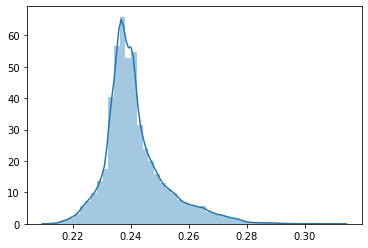

In [26]:
import seaborn as sns
sns.distplot(p.reshape(1,-1)[0])

In [27]:
training_epochs = 300
batch_size = 16
train_size = x_data.shape[0]

for epoch in tqdm(range(training_epochs)):
    X = x_data.copy()
    Y = y_data.copy()
    for batch in range(int(train_size/batch_size)+1):
        
        if X.shape[0] > batch_size:
            random_index = random.sample(list(range(X.shape[0])), batch_size)

            x_sample = np.array(X.loc[random_index, :])
            y_sample = np.array(Y.loc[random_index])

            X = X[~X.index.isin(random_index)].reset_index(drop=True)
            Y = Y[~Y.index.isin(random_index)].reset_index(drop=True)
        else:
            x_sample = np.array(X)
            y_sample = np.array(Y)
            
        sess.run(train, feed_dict = {x:x_sample, y:y_sample})
        
    if (epoch+1)%10 == 0:
        c_train = sess.run(loss, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_pred = sess.run(a4, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_threshold = np.median(training_pred)
        training_pred = [1 if i>training_threshold else 0 for i in training_pred]
        training_accuracy = accuracy_score(y_data, training_pred)
        
        print("Epoch", (epoch + 1), ": Train loss =", c_train/x_data.shape[0], "Training accuracy =", training_accuracy) 

  3%|▎         | 10/300 [01:40<48:49, 10.10s/it]

Epoch 10 : Train loss = 17984.807837597124 Training accuracy = 0.6286047725806947


  7%|▋         | 20/300 [03:17<45:46,  9.81s/it]

Epoch 20 : Train loss = 17985.596019778262 Training accuracy = 0.631184545929179


 10%|█         | 30/300 [04:57<45:10, 10.04s/it]

Epoch 30 : Train loss = 17986.781241362365 Training accuracy = 0.6370811707257148


 13%|█▎        | 40/300 [06:37<43:29, 10.04s/it]

Epoch 40 : Train loss = 17986.51589324652 Training accuracy = 0.6383096342249931


 17%|█▋        | 50/300 [08:16<41:15,  9.90s/it]

Epoch 50 : Train loss = 17987.107521267775 Training accuracy = 0.6467246091950493


 20%|██        | 60/300 [10:02<42:55, 10.73s/it]

Epoch 60 : Train loss = 17986.751758238384 Training accuracy = 0.6485058812690028


 23%|██▎       | 70/300 [11:47<40:24, 10.54s/it]

Epoch 70 : Train loss = 17988.106016399986 Training accuracy = 0.6535425816160437


 27%|██▋       | 80/300 [13:29<37:42, 10.29s/it]

Epoch 80 : Train loss = 17988.13746506557 Training accuracy = 0.6534197352661159


 30%|███       | 90/300 [15:11<35:39, 10.19s/it]

Epoch 90 : Train loss = 17988.86864654034 Training accuracy = 0.6532354657412242


 33%|███▎      | 100/300 [16:56<35:53, 10.77s/it]

Epoch 100 : Train loss = 17988.66226467246 Training accuracy = 0.6566751635392033


 37%|███▋      | 110/300 [18:41<32:45, 10.34s/it]

Epoch 110 : Train loss = 17989.34430760726 Training accuracy = 0.6564908940143116


 40%|████      | 120/300 [20:22<29:57,  9.98s/it]

Epoch 120 : Train loss = 17989.36003194005 Training accuracy = 0.6585792819630847


 43%|████▎     | 130/300 [22:04<29:09, 10.29s/it]

Epoch 130 : Train loss = 17989.301065692085 Training accuracy = 0.6627560578606309


 47%|████▋     | 140/300 [23:48<28:27, 10.67s/it]

Epoch 140 : Train loss = 17989.536930683946 Training accuracy = 0.6628174810355947


 50%|█████     | 150/300 [25:29<25:24, 10.16s/it]

Epoch 150 : Train loss = 17989.831761923775 Training accuracy = 0.6661343324836461


 53%|█████▎    | 160/300 [27:12<24:00, 10.29s/it]

Epoch 160 : Train loss = 17990.380148029853 Training accuracy = 0.6652744080341513


 57%|█████▋    | 170/300 [28:54<22:17, 10.29s/it]

Epoch 170 : Train loss = 17991.272503915727 Training accuracy = 0.67043395473112


 60%|██████    | 180/300 [30:37<20:27, 10.23s/it]

Epoch 180 : Train loss = 17990.57080556494 Training accuracy = 0.6700039925063727


 63%|██████▎   | 190/300 [32:20<18:59, 10.36s/it]

Epoch 190 : Train loss = 17991.21550320936 Training accuracy = 0.6737508061791714


 67%|██████▋   | 200/300 [34:04<17:16, 10.37s/it]

Epoch 200 : Train loss = 17989.590000307115 Training accuracy = 0.6736893830042074


 70%|███████   | 210/300 [35:46<15:35, 10.39s/it]

Epoch 210 : Train loss = 17991.294124873315 Training accuracy = 0.6744878842787384


 73%|███████▎  | 220/300 [37:27<13:32, 10.16s/it]

Epoch 220 : Train loss = 17991.258745124534 Training accuracy = 0.676146310002764


 77%|███████▋  | 230/300 [39:08<11:39, 10.00s/it]

Epoch 230 : Train loss = 17992.11768680323 Training accuracy = 0.674764288566076


 80%|████████  | 240/300 [40:49<10:15, 10.26s/it]

Epoch 240 : Train loss = 17990.777187432817 Training accuracy = 0.6765455606400295


 83%|████████▎ | 250/300 [42:29<08:21, 10.03s/it]

Epoch 250 : Train loss = 17992.20613617518 Training accuracy = 0.6793403151008875


 87%|████████▋ | 260/300 [44:10<06:41, 10.03s/it]

Epoch 260 : Train loss = 17991.76388931544 Training accuracy = 0.6814901262246246


 90%|█████████ | 270/300 [45:50<05:04, 10.16s/it]

Epoch 270 : Train loss = 17992.32406867111 Training accuracy = 0.6824114738490833


 93%|█████████▎| 280/300 [47:29<03:19,  9.96s/it]

Epoch 280 : Train loss = 17992.37713829428 Training accuracy = 0.6821964927367096


 97%|█████████▋| 290/300 [49:11<01:40, 10.06s/it]

Epoch 290 : Train loss = 17991.704923067475 Training accuracy = 0.6803845090752741


100%|██████████| 300/300 [50:52<00:00, 10.17s/it]

Epoch 300 : Train loss = 17992.654279659717 Training accuracy = 0.6868339424464851


In [28]:
p = sess.run(a4, feed_dict = {x:np.array(x_data), y:np.array(y_data)})

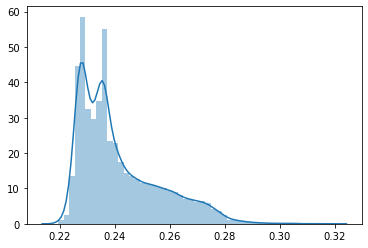

In [29]:
sns.distplot(p.reshape(1,-1)[0])

In [30]:
np.median(p)

0.23610806

In [31]:
from sklearn.metrics import f1_score, plot_confusion_matrix
f1_score(y_data, training_pred)

0.5772563326561917

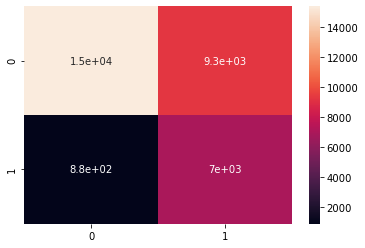

In [32]:
sns.heatmap(confusion_matrix(y_data, training_pred), annot=True)

In [33]:
tn, fp, fn, tp = confusion_matrix(y_data, training_pred).ravel()

In [34]:
print(tn, fp, fn, tp)

15402 9318 879 6962


In [35]:
tn, fp, fn, tp = confusion_matrix(y_data, training_pred).ravel()
print(tn, fp, fn, tp)

15402 9318 879 6962


In [36]:
f1_score(y_data, training_pred)

0.5772563326561917

In [37]:
training_epochs = 500
batch_size = 16
train_size = x_data.shape[0]

for epoch in tqdm(range(training_epochs)):
    X = x_data.copy()
    Y = y_data.copy()
    for batch in range(int(train_size/batch_size)+1):
        
        if X.shape[0] > batch_size:
            random_index = random.sample(list(range(X.shape[0])), batch_size)

            x_sample = np.array(X.loc[random_index, :])
            y_sample = np.array(Y.loc[random_index])

            X = X[~X.index.isin(random_index)].reset_index(drop=True)
            Y = Y[~Y.index.isin(random_index)].reset_index(drop=True)
        else:
            x_sample = np.array(X)
            y_sample = np.array(Y)
            
        sess.run(train, feed_dict = {x:x_sample, y:y_sample})
        
    if (epoch+1)%10 == 0:
        c_train = sess.run(loss, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_pred = sess.run(a4, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_threshold = np.median(training_pred)
        training_pred = [1 if i>training_threshold else 0 for i in training_pred]
        training_accuracy = accuracy_score(y_data, training_pred)
        training_f1 = f1_score(y_data, training_pred)
        
        print("Epoch", (epoch + 1), ": Train loss =", c_train/x_data.shape[0], "Training accuracy =", training_accuracy, 'f1_score:', training_f1)

  2%|▏         | 10/500 [01:39<1:20:45,  9.89s/it]

Epoch 10 : Train loss = 17993.29308067934 Training accuracy = 0.6844077270354104 f1_score: 0.5739635157545605


  4%|▍         | 20/500 [03:19<1:19:56,  9.99s/it]

Epoch 20 : Train loss = 17992.076410429654 Training accuracy = 0.6870489235588587 f1_score: 0.576510680741418


  6%|▌         | 30/500 [04:59<1:19:20, 10.13s/it]

Epoch 30 : Train loss = 17992.402690335064 Training accuracy = 0.6843155922729646 f1_score: 0.5729006523455353


  8%|▊         | 40/500 [06:38<1:16:32,  9.98s/it]

Epoch 40 : Train loss = 17993.393323300883 Training accuracy = 0.6866803845090753 f1_score: 0.5769964341985239


 10%|█         | 50/500 [08:19<1:16:00, 10.13s/it]

Epoch 50 : Train loss = 17991.875925186574 Training accuracy = 0.6826571665489389 f1_score: 0.5716180921189006


 12%|█▏        | 60/500 [09:57<1:12:34,  9.90s/it]

Epoch 60 : Train loss = 17992.125548969627 Training accuracy = 0.6828414360738306 f1_score: 0.5718668380249575


 14%|█▍        | 70/500 [11:34<1:09:36,  9.71s/it]

Epoch 70 : Train loss = 17993.015939313904 Training accuracy = 0.686158287521882 f1_score: 0.5763442643339828


 16%|█▌        | 80/500 [13:12<1:08:37,  9.80s/it]

Epoch 80 : Train loss = 17993.49749700562 Training accuracy = 0.6851140935474954 f1_score: 0.5749347041996601


 18%|█▊        | 90/500 [14:50<1:08:52, 10.08s/it]

Epoch 90 : Train loss = 17993.067043395473 Training accuracy = 0.6867418076840391 f1_score: 0.5771144278606966


 20%|██        | 100/500 [16:28<1:05:27,  9.82s/it]

Epoch 100 : Train loss = 17994.45275022266 Training accuracy = 0.6838242068732533 f1_score: 0.5731934828572612


 22%|██▏       | 110/500 [18:08<1:05:10, 10.03s/it]

Epoch 110 : Train loss = 17991.94471914253 Training accuracy = 0.6857897484720985 f1_score: 0.5758467725218689


 24%|██▍       | 120/500 [19:46<1:02:24,  9.85s/it]

Epoch 120 : Train loss = 17993.743189705478 Training accuracy = 0.6850526703725316 f1_score: 0.5748517888976411


 26%|██▌       | 130/500 [21:25<1:00:24,  9.79s/it]

Epoch 130 : Train loss = 17994.150056816437 Training accuracy = 0.6859740179969903 f1_score: 0.576095518427926


 28%|██▊       | 140/500 [23:05<59:56,  9.99s/it]  

Epoch 140 : Train loss = 17993.813949203035 Training accuracy = 0.6874481741961243 f1_score: 0.5780854856763815


 30%|███       | 150/500 [24:44<58:09,  9.97s/it]  

Epoch 150 : Train loss = 17993.900433033385 Training accuracy = 0.6856976137096527 f1_score: 0.5757048092868988


 32%|███▏      | 160/500 [26:23<55:49,  9.85s/it]

Epoch 160 : Train loss = 17994.328921101933 Training accuracy = 0.6859740179969903 f1_score: 0.576095518427926


 34%|███▍      | 170/500 [28:02<55:19, 10.06s/it]

Epoch 170 : Train loss = 17994.155953441234 Training accuracy = 0.6885537913454747 f1_score: 0.5795779611127234


 36%|███▌      | 180/500 [29:41<52:19,  9.81s/it]

Epoch 180 : Train loss = 17993.7019133319 Training accuracy = 0.6868339424464851 f1_score: 0.5772563326561917


 38%|███▊      | 190/500 [31:20<50:42,  9.81s/it]

Epoch 190 : Train loss = 17992.691624950094 Training accuracy = 0.6859740179969903 f1_score: 0.576095518427926


 40%|████      | 200/500 [33:00<50:27, 10.09s/it]

Epoch 200 : Train loss = 17993.17514818341 Training accuracy = 0.6902736402444642 f1_score: 0.581899589569255


 42%|████▏     | 210/500 [34:37<47:00,  9.73s/it]

Epoch 210 : Train loss = 17994.608028008966 Training accuracy = 0.6872024814962685 f1_score: 0.5777538244683057


 44%|████▍     | 220/500 [36:17<46:53, 10.05s/it]

Epoch 220 : Train loss = 17995.109241116672 Training accuracy = 0.6864039802217377 f1_score: 0.5766759255420588


 46%|████▌     | 230/500 [37:57<45:43, 10.16s/it]

Epoch 230 : Train loss = 17993.642947083936 Training accuracy = 0.6880009827707995 f1_score: 0.5788317233945525


 48%|████▊     | 240/500 [39:34<42:37,  9.84s/it]

Epoch 240 : Train loss = 17994.68664967292 Training accuracy = 0.6870796351463407 f1_score: 0.5775879938642676


 50%|█████     | 250/500 [41:13<41:23,  9.93s/it]

Epoch 250 : Train loss = 17995.038481619114 Training accuracy = 0.688983753570222 f1_score: 0.5801583682268563


 52%|█████▏    | 260/500 [42:53<40:54, 10.23s/it]

Epoch 260 : Train loss = 17994.50581984583 Training accuracy = 0.6887994840453303 f1_score: 0.5799096223207992


 54%|█████▍    | 270/500 [44:32<38:08,  9.95s/it]

Epoch 270 : Train loss = 17995.0679647431 Training accuracy = 0.6903350634194282 f1_score: 0.581982504871274


 56%|█████▌    | 280/500 [46:12<36:28,  9.95s/it]

Epoch 280 : Train loss = 17993.489634839225 Training accuracy = 0.6884309449955468 f1_score: 0.5794121305086853


 58%|█████▊    | 290/500 [47:53<36:01, 10.29s/it]

Epoch 290 : Train loss = 17995.124965449464 Training accuracy = 0.6879395595958355 f1_score: 0.5787488080925336


 60%|██████    | 300/500 [49:36<34:08, 10.24s/it]

Epoch 300 : Train loss = 17995.53969472682 Training accuracy = 0.6913792573938147 f1_score: 0.5833920650055968


 62%|██████▏   | 310/500 [51:22<33:07, 10.46s/it]

Epoch 310 : Train loss = 17996.35736003194 Training accuracy = 0.6888916188077762 f1_score: 0.5800165837479271


 64%|██████▍   | 320/500 [53:06<31:44, 10.58s/it]

Epoch 320 : Train loss = 17996.027149043333 Training accuracy = 0.6903350634194282 f1_score: 0.581982504871274


 66%|██████▌   | 330/500 [54:51<30:06, 10.62s/it]

Epoch 330 : Train loss = 17995.72642117871 Training accuracy = 0.6884923681705107 f1_score: 0.5794950458107043


 68%|██████▊   | 340/500 [56:35<27:44, 10.40s/it]

Epoch 340 : Train loss = 17995.25076011179 Training accuracy = 0.6879395595958355 f1_score: 0.5787488080925336


 70%|███████   | 350/500 [58:22<26:45, 10.70s/it]

Epoch 350 : Train loss = 17994.70630508891 Training accuracy = 0.6910721415189951 f1_score: 0.5829774884955018


 72%|███████▏  | 360/500 [1:00:08<24:44, 10.60s/it]

Epoch 360 : Train loss = 17995.229139154202 Training accuracy = 0.6920549123184178 f1_score: 0.5842696629213483


 74%|███████▍  | 370/500 [1:01:53<23:03, 10.64s/it]

Epoch 370 : Train loss = 17995.288105402167 Training accuracy = 0.6913178342188507 f1_score: 0.5833091497035778


 76%|███████▌  | 380/500 [1:03:38<21:06, 10.56s/it]

Epoch 380 : Train loss = 17994.588372592978 Training accuracy = 0.6891680230951138 f1_score: 0.5804071141329132


 78%|███████▊  | 390/500 [1:05:25<19:19, 10.54s/it]

Epoch 390 : Train loss = 17994.653235465743 Training accuracy = 0.6899665243696447 f1_score: 0.5814850130591601


 80%|████████  | 400/500 [1:07:11<17:38, 10.59s/it]

Epoch 400 : Train loss = 17995.72445563711 Training accuracy = 0.6887994840453303 f1_score: 0.5799096223207992


 82%|████████▏ | 410/500 [1:08:56<16:08, 10.76s/it]

Epoch 410 : Train loss = 17994.617855716962 Training accuracy = 0.6915635269187064 f1_score: 0.5836062855010573


 84%|████████▍ | 420/500 [1:10:41<14:04, 10.56s/it]

Epoch 420 : Train loss = 17994.902859248796 Training accuracy = 0.6915021037437425 f1_score: 0.5835233633235208


 86%|████████▌ | 430/500 [1:12:27<12:22, 10.61s/it]

Epoch 430 : Train loss = 17995.512177144436 Training accuracy = 0.6914713921562605 f1_score: 0.5834991708126037


 88%|████████▊ | 440/500 [1:14:15<10:46, 10.78s/it]

Epoch 440 : Train loss = 17995.431589938886 Training accuracy = 0.6895979853198612 f1_score: 0.580987521247046


 90%|█████████ | 450/500 [1:16:02<09:01, 10.84s/it]

Epoch 450 : Train loss = 17995.001136328738 Training accuracy = 0.6867725192715212 f1_score: 0.5771734173541728


 92%|█████████▏| 460/500 [1:17:47<07:10, 10.76s/it]

Epoch 460 : Train loss = 17995.468935229263 Training accuracy = 0.6884923681705107 f1_score: 0.5794950458107043


 94%|█████████▍| 470/500 [1:19:33<05:18, 10.62s/it]

Epoch 470 : Train loss = 17994.97951537115 Training accuracy = 0.6875095973710881 f1_score: 0.5781684009784005


 96%|█████████▌| 480/500 [1:21:20<03:31, 10.57s/it]

Epoch 480 : Train loss = 17995.869905715426 Training accuracy = 0.6924234513682013 f1_score: 0.5848016251399196


 98%|█████████▊| 490/500 [1:23:06<01:46, 10.68s/it]

Epoch 490 : Train loss = 17996.211909953625 Training accuracy = 0.6899358127821628 f1_score: 0.5814262023217247


100%|██████████| 500/500 [1:24:52<00:00, 10.19s/it]

Epoch 500 : Train loss = 17997.14357667148 Training accuracy = 0.693959030742299 f1_score: 0.5867374445319952


In [38]:
tn, fp, fn, tp = confusion_matrix(y_data, training_pred).ravel()
print(tn, fp, fn, tp)

15522 9198 767 7074


In [40]:
p = sess.run(a4, feed_dict = {x:np.array(x_data), y:np.array(y_data)})

In [ ]:
sns.distplot(p.reshape(1,-1)[0])